# <p style="text-align: center;">Calibration sur les données de Chong et Menberg (2018)</p>

#### Chargement des librairies Python

In [99]:
import os
# os.environ["OMP_NUM_THREADS"] = "1"
# os.environ["MKL_NUM_THREADS"] = "1"
# os.environ["OPENBLAS_NUM_THREADS"] = "1"
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import pymc as pm
import arviz as az
import pandas as pd
import seaborn as sns
import pytensor.tensor as pt
import pytensor
from pytensor.tensor.slinalg import cholesky
import scipy as sp
import Predictions
from multiprocessing import Pool
from functools import partial

In [100]:
# Augmentation de la résolution des images affichées
%config InlineBackend.figure_format = 'retina'

# Fenêtre graphique avec grilles 
az.style.use("arviz-darkgrid")

# Initialisation de la graine utilisée pour générer les données
seed = 2024
rng = np.random.default_rng(seed)

#### Quelques réglages préliminaire

In [101]:
# Chemin où se trouvent les fichiers contenant les données
path = "D:/Projet/Thesis/Simulations/Calibration"

#### Lecture des jeux de données

In [102]:
# année d'entrainement
# Lecture des deux datasets
datacomp_training = pd.read_csv(os.path.join(path, "2022/datacomp.csv"), header = 0)
datacomp_test = pd.read_csv(os.path.join(path, "2023/datacomp.csv"), header = 0)

In [103]:
# Affichage des données simulées
datacomp_training

,ElecCons,Temperature_db,Relative_humidity,DNI,Infiltration,Power_density,Mechanical_ventilation
0,3579.94,4.290323,90.037634,51.616935,1399.335775,6.225480,0.002281
1,2346.54,4.290323,90.037634,51.616935,633.863202,5.028213,0.000413
2,3996.86,4.290323,90.037634,51.616935,2124.671004,11.146091,0.003338
3,3718.60,4.290323,90.037634,51.616935,1374.080545,9.938760,0.002719
4,3459.89,4.290323,90.037634,51.616935,857.687724,10.127447,0.003706
...,...,...,...,...,...,...,...
187,2386.29,4.717742,88.505376,46.532258,687.683930,5.298301,0.000103
188,3105.38,4.717742,88.505376,46.532258,1634.615320,4.390946,0.001040
189,3619.95,4.717742,88.505376,46.532258,2280.149349,10.530785,0.002434
190,2803.47,4.717742,88.505376,46.532258,909.953620,8.173994,0.000978


#### Description des données

La sortie étudiée est la consommation electrique mensuelle. 12 mois de l'an 2023 ont été utilisés comme jeu de données d'entrainement contre 6 mois pour le jeu de données de test. Les variables observables sont-elles au nombre de 3, et correspondent à la température sèche exterieur, l'humidité exterieur relative et le taux de radiation solaire direct par unité d'aire. Au préalable, une analyse de sensibilité a été réalisée afin de déterminer les variables incertaines les plus influents sur le modèle parmi 14 variables. Ainsi, 3 variables incertaines ont été choisies pour notre jeu de données, l'efficacité des ventilateurs, la densité de puissance des équipements electriques et enfin l'infiltration.

Il y a ici deux jeux de données, le premier, datafield représente les données observées. La variable $Energy_consumption$ correspond à la consommation électrique mensuelle mesurée pour chaque mois. La variable $x_f$ contient chacune des 3 variables observées pour chacun des 12 mois.

Le second jeu de données, datacomp_training, représente les données simulées pour l'entrainement du métamodèle. De plus, pour chaque valeur de $x_f$, 50 simulations des variables incertaines ont été effectuées ce qui donne donc 12*50=600 simulations. Ainsi, la variable $t_c$ correspond aux valeurs simulées des 3 variables incertaines. Le modèle physique a été évalué en chacun des 600 points et ces évaluations correspondent à la variable $\eta$.

On note de plus $t_f$ étant les variables incertaines dont on souhaite obtenir la distribution à posteriori.

#### Définition des différentes variables des jeux de données

In [104]:
# renommer les colomns de manière générale
datacomp_training.columns = ['EC_c', 'TDB', 'HR', 'DNI', 'INF', 'MV', 'EPD']

# Obtention des données simulées
eta_training = datacomp_training["EC_c"]
xc_training = datacomp_training.drop(['EC_c', 'INF', 'MV', 'EPD'], axis = 1)
tc_training = datacomp_training.drop(['EC_c', 'TDB', 'HR', 'DNI'], axis = 1)

# renommer les colomns de manière générale
datacomp_test.columns = ['EC_c', 'TDB', 'HR', 'DNI', 'INF', 'MV', 'EPD']

# Obtention des données simulées
eta_test = datacomp_test["EC_c"]
xc_test = datacomp_test.drop(['EC_c', 'INF', 'MV', 'EPD'], axis = 1)
tc_test = datacomp_test.drop(['EC_c', 'TDB', 'HR', 'DNI'], axis = 1)

# Nombre de simulations et nombre de paramètres incertains
m_training, q = tc_training.shape
p = xc_training.shape[1]

#### Normalisation des variables 

Dans le papier de Chong et Menberg, les variables $\eta$ et $y$ sont toutes deux normalisées par la moyenne et la variance de $\eta$, et les variables $x_f$, $x_c$ et $t_c$ sont transformées de sorte à être dans l'intervalle [0,1].

In [105]:
# "Standardisation" des variables eta et y
eta_mean = eta_training.mean()
eta_sd = eta_training.std()
eta_training_std = (eta_training - eta_mean) /eta_sd

# Normalisation min-max des variables observées
x_min = np.min(xc_training, axis = 0)
x_max = np.max(xc_training, axis = 0)
xc_training_std = (xc_training - x_min) / (x_max - x_min)

# Normalisation min-max des variables incertaines
tc_min = pd.Series([440, 0, 4], index = tc_training.columns)
tc_max = pd.Series([2480, 0.0038, 12], index = tc_training.columns)
tc_training_std = (tc_training - tc_min) / (tc_max - tc_min)
Xnew_training = np.concatenate((xc_training_std, tc_training_std), axis = 1)

In [106]:
# "Standardisation" des variables eta et y
eta_test_std = (eta_test - eta_mean) /eta_sd

# Normalisation min-max des variables observées
x_min = np.min(xc_test, axis = 0)
x_max = np.max(xc_test, axis = 0)
xc_test_std = (xc_test - x_min) / (x_max - x_min)

# Normalisation min-max des variables incertaines
tc_test_std = (tc_test - tc_min) / (tc_max - tc_min)
Xnew_test = np.concatenate((xc_test_std, tc_test_std), axis = 1)

#### Définition de l'échantillon complet

Dans cette étude, l'échantillon complet correspond aux observations $y$ et aux simulations $\eta$.

In [107]:
# Initialisation des modèle via PyMC
NI_model = pm.Model()

# Elaboration du modèle
with NI_model:    

    # Echantillon complet
    eta_obs = pm.Data("eta_obs", eta_training_std)

    # Variables simulées
    xc_sim = pm.Data("xc_obs", xc_training_std)
    tc_sim = pm.Data("tc_obs", tc_training_std)

    # Définition des priors pour les hyperparamètres
    rho_eta = pm.Beta("rho_eta", alpha = 2, beta = 0.5, shape = p+q)
    lambda_eta = pm.Gamma("lambda_eta", alpha = 5, beta = 5)
    # sigma_eta = pm.HalfNormal("sigma_eta", sigma = 5)
    sigma_eps = pm.HalfNormal("sigma_eps", sigma = 0.25)

    # Transformation de certains hyperparamètres
    beta_eta = pm.Deterministic("beta_eta", -4.0*pt.log(rho_eta))

    # Ensemble des données simulées
    xt = pt.concatenate((xc_sim, tc_sim), axis = 1)
    
    # Matrice de covariance de eta
    ls_eta = 1/pt.sqrt(2*beta_eta)
    cov_eta = 1/lambda_eta*pm.gp.cov.ExpQuad(p+q, ls = ls_eta)
    #cov_eta = sigma_eta**2*pm.gp.cov.ExpQuad(p+q, ls = ls_eta)
     
    # # Distribution de l'ensemble de l'échantillon
    GP_eta = pm.gp.Marginal(cov_func = cov_eta)
    likelihood = GP_eta.marginal_likelihood("likelihood", X=xt, y=eta_obs, sigma=sigma_eps)

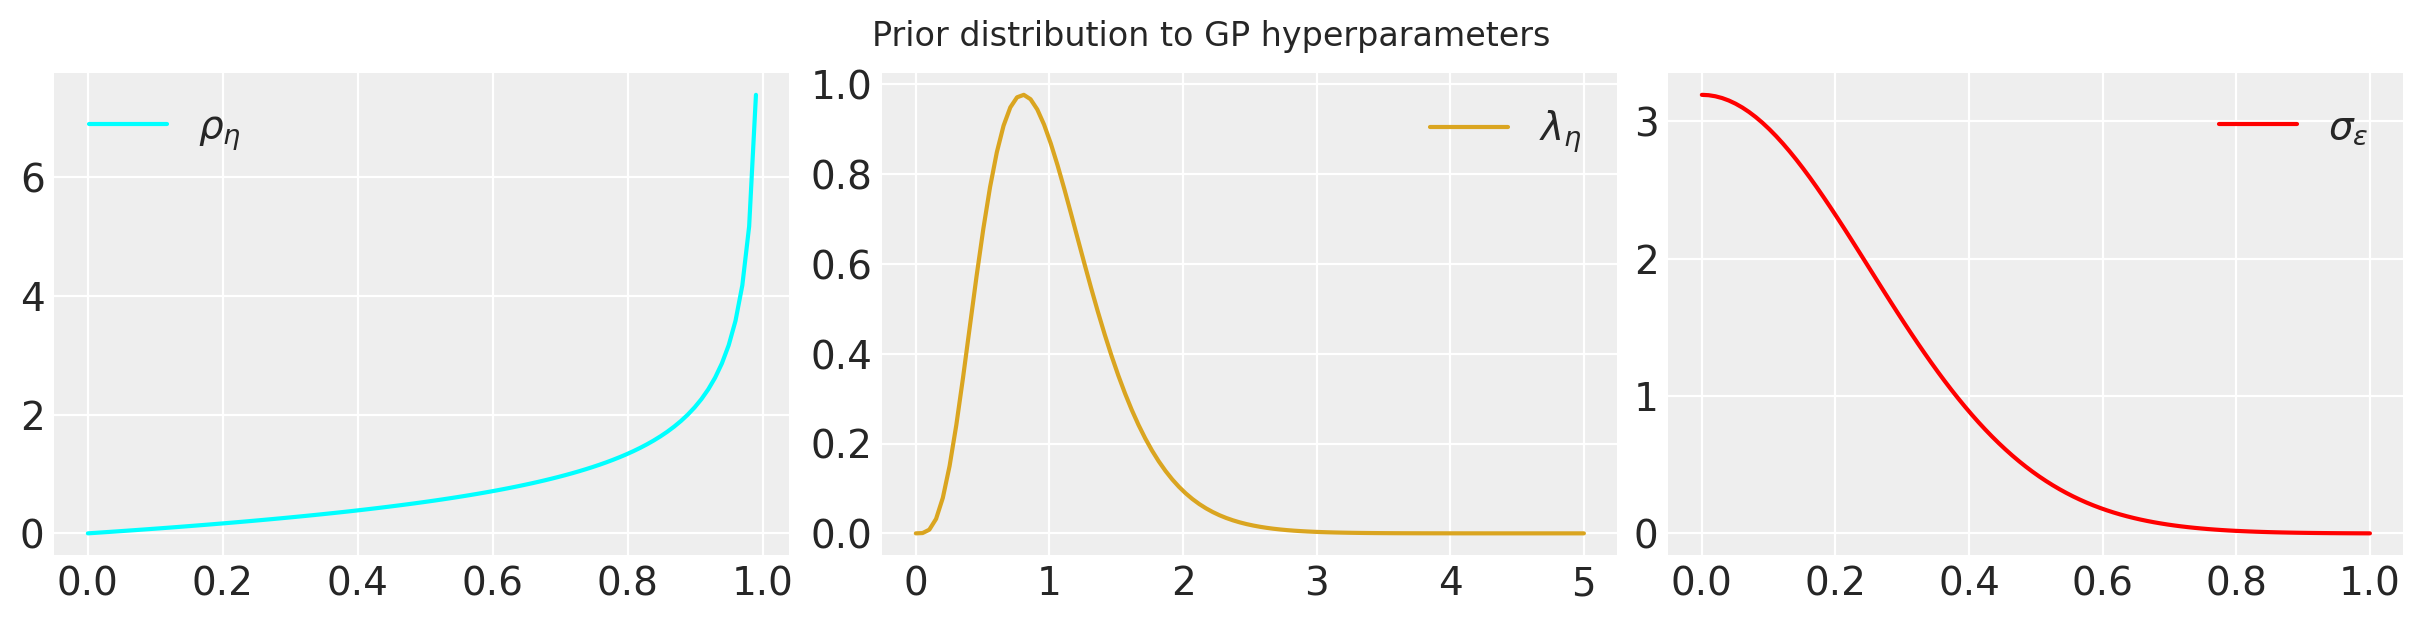

In [108]:
# **********BETA and GAMMA and HALFNORMAL Distributions ********************

fig, axs = plt.subplots(1, 3, figsize = (12, 3))
fig.suptitle(r"Prior distribution to GP hyperparameters")

#define x-axis values
x_beta = np.linspace(0, 1, 100)
x_gamma_lambda_eta = np.linspace(0, 5, 100)
x_halfnorm_sigma_eps = np.linspace(0, 1, 100)

#create plot of Beta and Gamma distributions pof GP's hyperparameters
axs[0].plot(x_beta, sp.stats.beta.pdf(x_beta, a=2, b=0.5), color='cyan', label=r'$\rho_{\eta}$')
axs[0].legend()
axs[1].plot(x_gamma_lambda_eta, sp.stats.gamma.pdf(x_gamma_lambda_eta, a=5, scale=0.2), color='goldenrod', label=r'$\lambda_{\eta}$')  #scale = 1/beta
axs[1].legend()
axs[2].plot(x_halfnormal_sigma, sp.stats.halfnorm.pdf(x_halfnorm_sigma_eps, loc=0, scale=0.25), color='red', label=r'$\sigma_{\epsilon}$')
axs[2].legend()

#display plot
plt.show()

In [109]:
# Burn-in et taille posteriors
n_tune = 10000
n_draws = 2000
chains = 4
cores = 12

In [110]:
with NI_model:
    idataNI = pm.sample(draws = n_draws, tune = n_tune, random_seed = rng, chains = chains, cores = cores, target_accept = 0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 12 jobs)
NUTS: [rho_eta, lambda_eta, sigma_eps]


Output()

Sampling 4 chains for 10_000 tune and 2_000 draw iterations (40_000 + 8_000 draws total) took 1484 seconds.


In [111]:
az.summary(idataNI, round_to = 2).drop(labels = ["mcse_mean", "mcse_sd", "ess_bulk", "ess_tail"], axis = 1)

,mean,sd,hdi_3%,hdi_97%,r_hat
beta_eta[0],4.13,3.91,0.55,13.30,1.0
beta_eta[1],1.65,1.14,0.00,3.57,1.0
beta_eta[2],0.89,0.95,0.00,2.54,1.0
beta_eta[3],0.52,0.25,0.16,0.98,1.0
beta_eta[4],0.00,0.00,0.00,0.00,1.0
beta_eta[5],1.15,1.63,0.00,4.03,1.0
lambda_eta,0.76,0.28,0.27,1.26,1.0
rho_eta[0],0.47,0.22,0.01,0.75,1.0
rho_eta[1],0.69,0.18,0.41,1.00,1.0
rho_eta[2],0.82,0.16,0.53,1.00,1.0


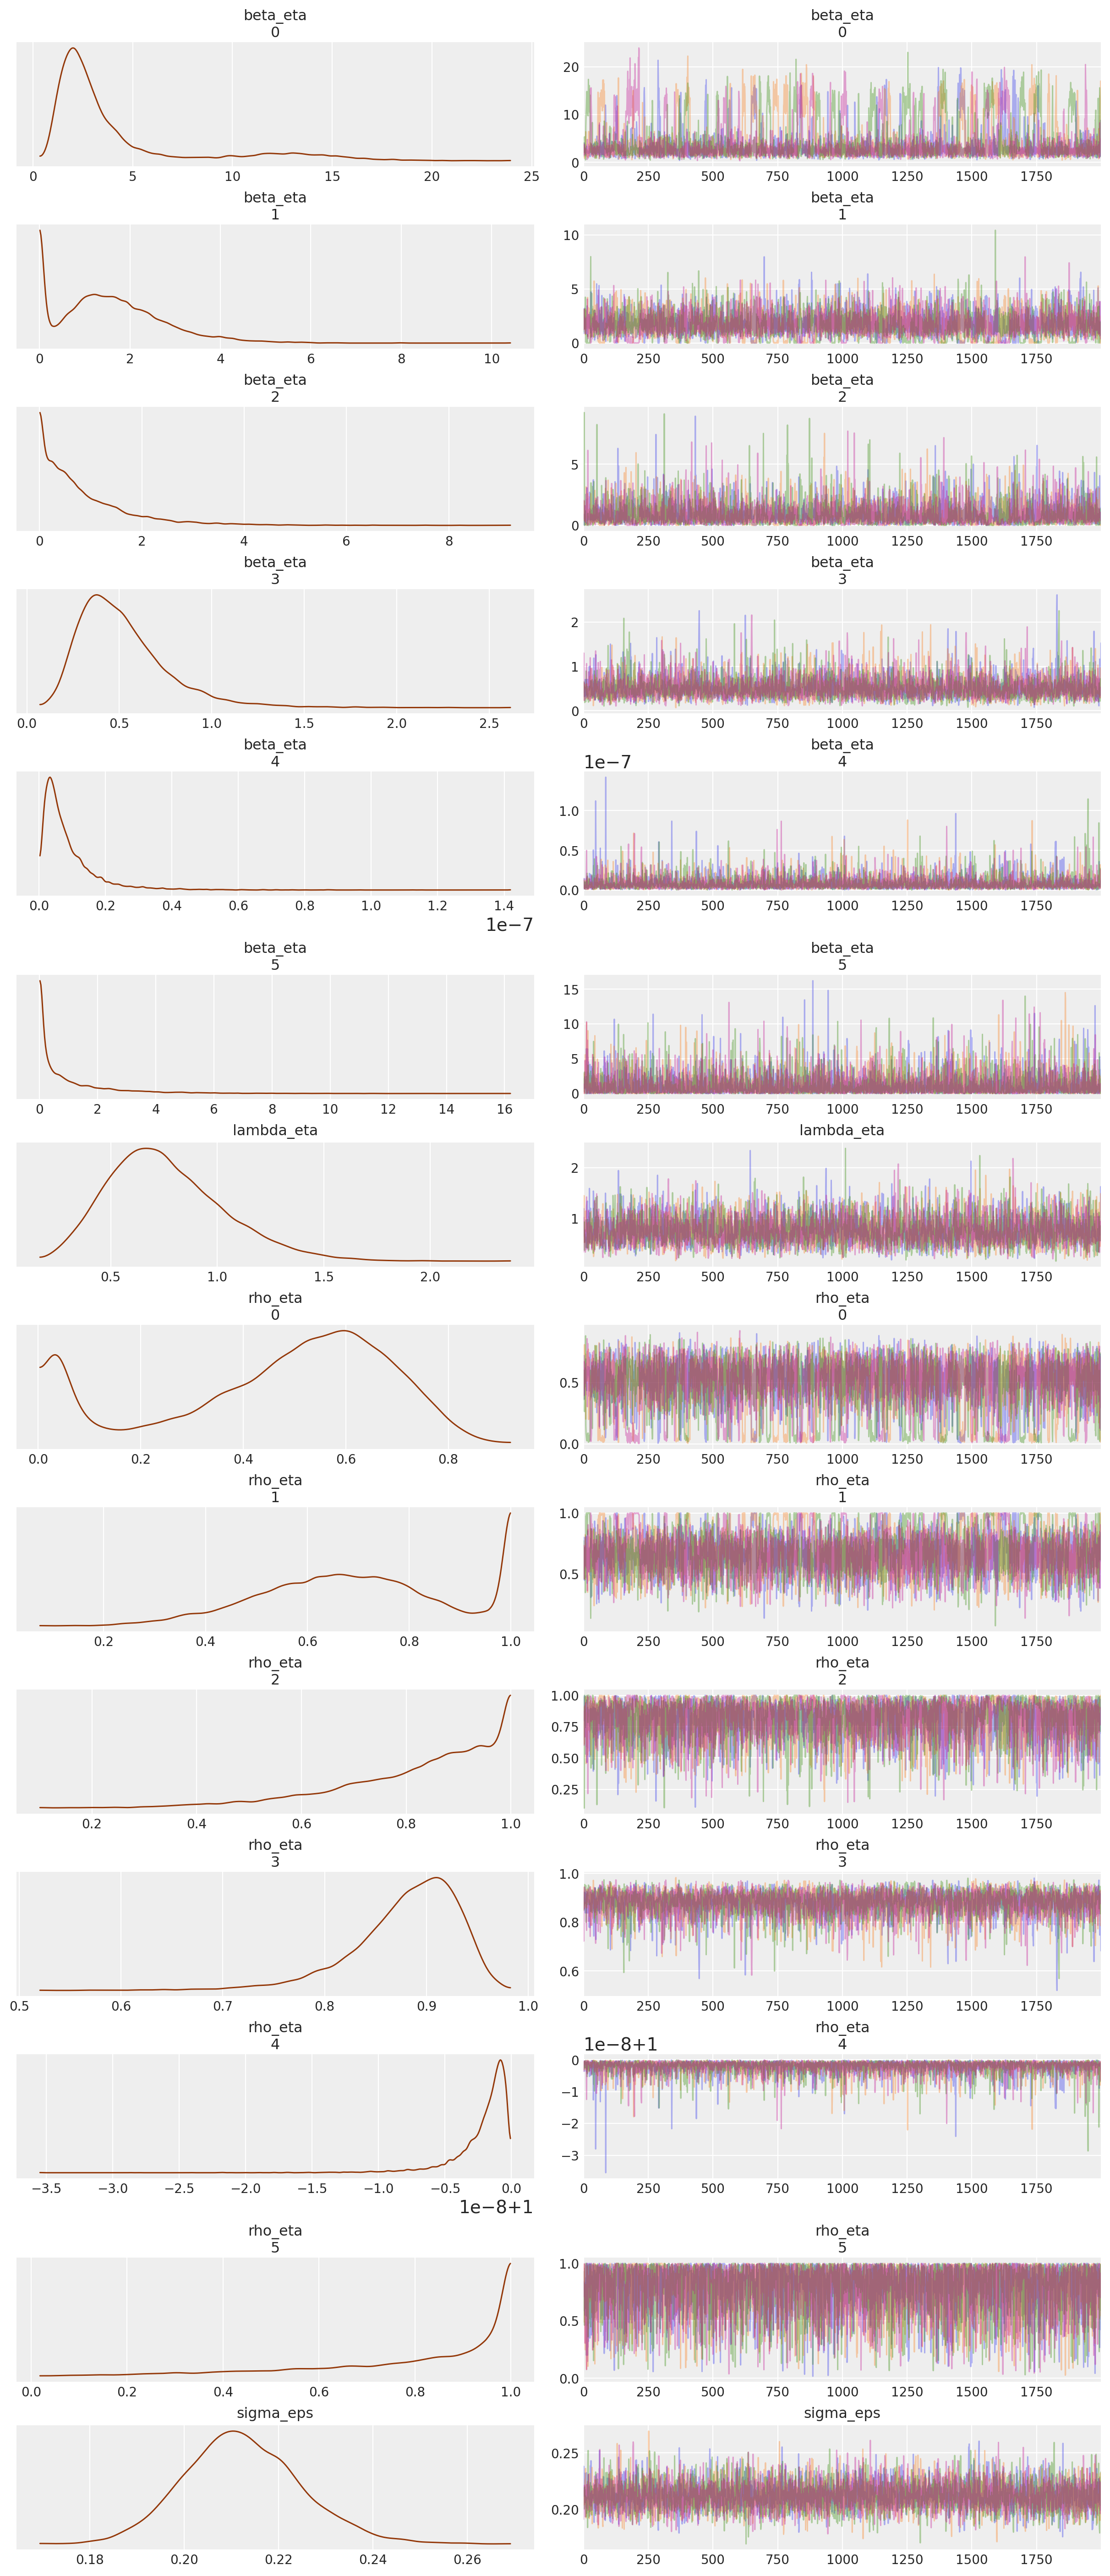

In [112]:
# Affichage des distributions à posteriori et des chaines de Markov pour chaque paramètre
az.plot_trace(idataNI, combined = True, compact = False);

#  Prédiction

In [113]:
Xnew = np.concatenate((Xnew_training, Xnew_test), axis = 0)
with NI_model:
    eta_pred = GP_eta.conditional("eta_pred", Xnew, pred_noise=True)
    eta_samples = pm.sample_posterior_predictive(idataNI, var_names=["eta_pred"])

Sampling: [eta_pred]


Output()

In [114]:
eta_pred_std = az.extract(eta_samples, group = "posterior_predictive", combined = True, var_names = "eta_pred")

In [115]:
eta_pred = eta_pred_std.values * eta_sd + eta_mean
eta_pred_training = eta_pred[:m_training]
eta_pred_test = eta_pred[m_training:]

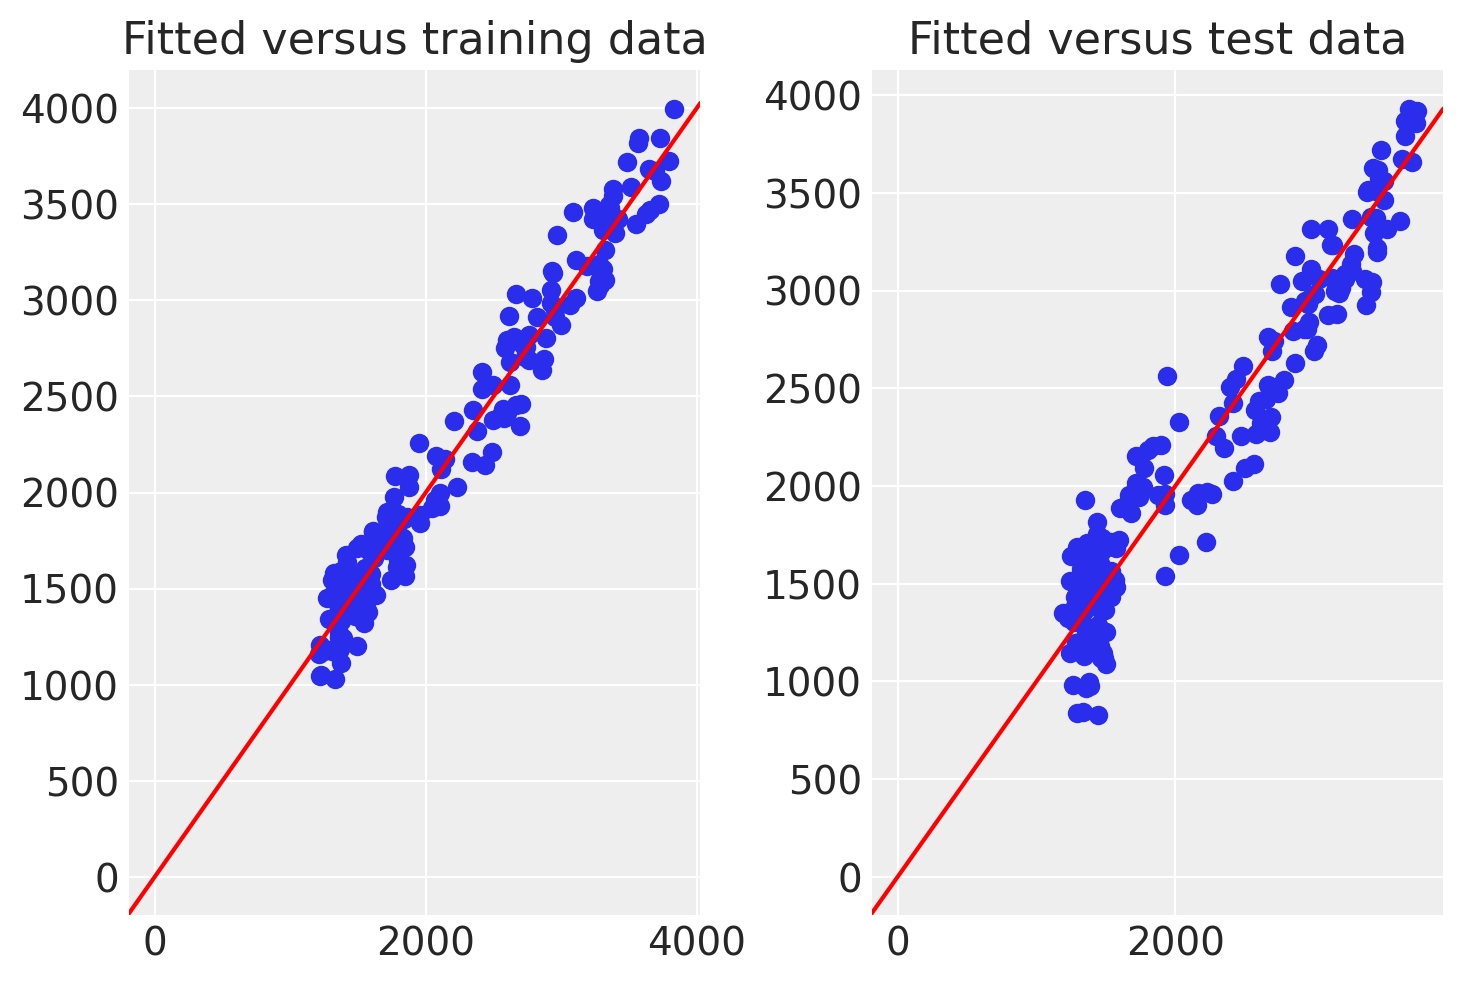

In [116]:
fig, ax = plt.subplots(1, 2)
ax[0].scatter(eta_pred_training.mean(axis = 1), eta_training)
ax[0].axline((0, 0), slope=1, color = 'red')
ax[0].set_title("Fitted versus training data")

ax[1].scatter(eta_pred_test.mean(axis = 1), eta_test)
ax[1].axline((0, 0), slope=1, color = 'red')
ax[1].set_title("Fitted versus test data")
plt.show()

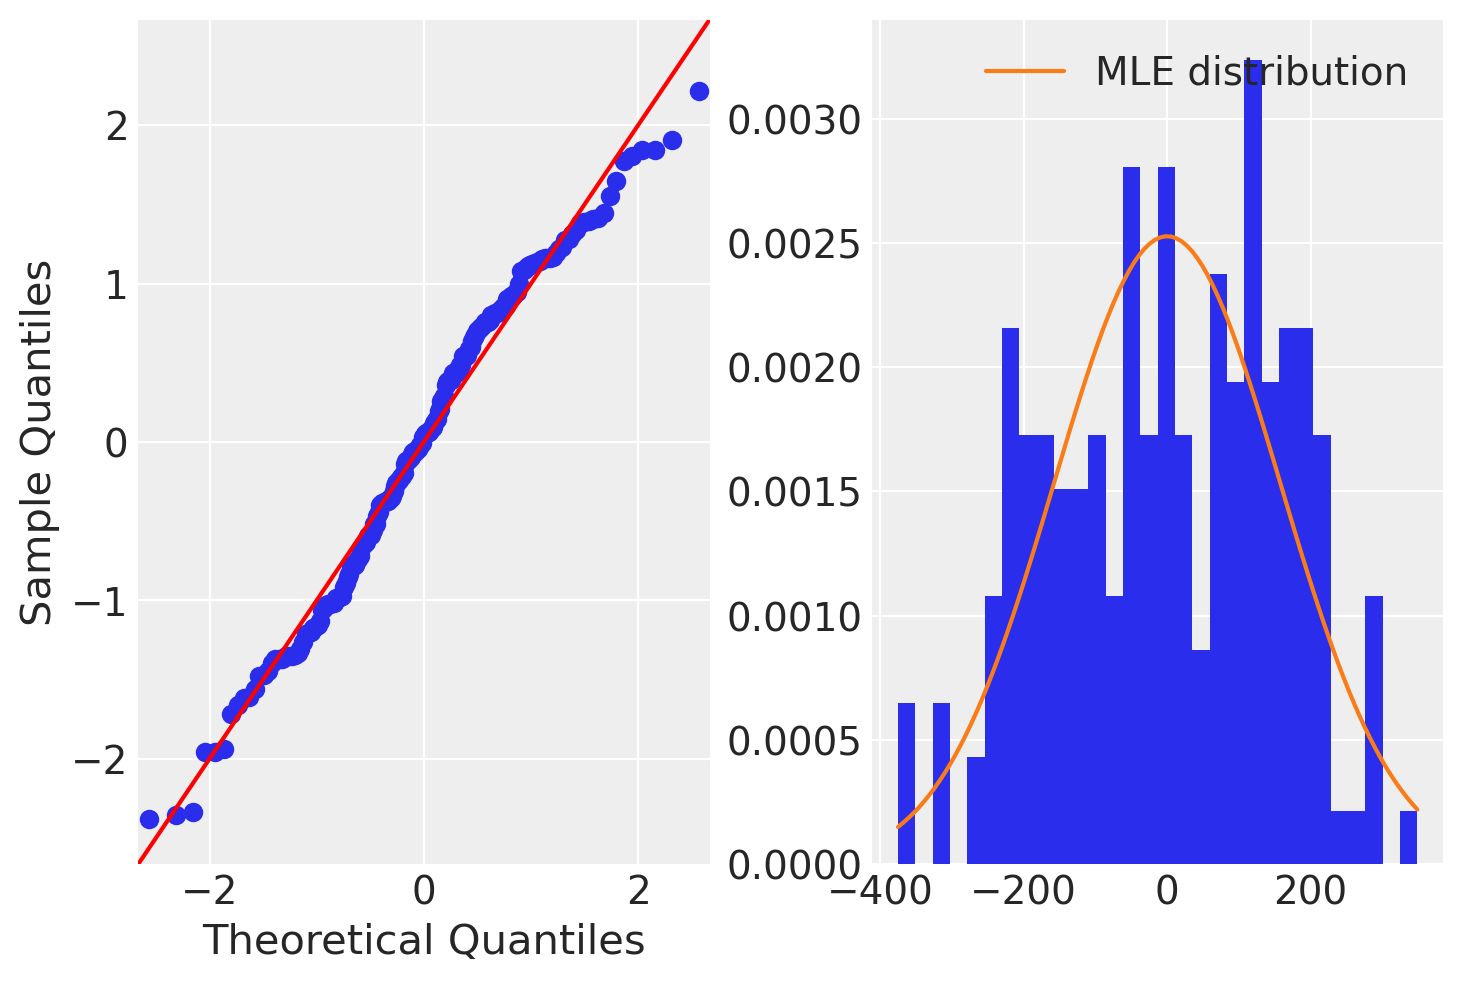

In [117]:
residuals = eta_pred_training.mean(axis = 1) - eta_training
tt = np.linspace(np.min(residuals), np.max(residuals), 100)
fig, ax = plt.subplots(1, 2)
sm.qqplot(residuals, line = '45', fit = True, ax = ax[0]);
ax[1].hist(residuals, bins = 30, density = True);
ax[1].plot(tt, sp.stats.norm.pdf(tt, loc = residuals.mean(), scale = residuals.std()), label = "MLE distribution");
ax[1].legend();
plt.show()

In [118]:
sp.stats.shapiro(residuals).pvalue

0.00994930053242949

#### Définition du modèle bayésien

Le modèle complet est défini comme suit:

$$y(x,t)=\eta(x,t)+\delta(x)+\epsilon,$$

où $\epsilon\sim\mathcal{N}(0,\sigma^2)$, avec $\sigma>0$. On suppose que les $\epsilon_i$ sont identiquement et indépendemment distribués (i.i.d).

Dans le papier de Chong, $\eta$ et $\delta$ sont tous deux modélisés par des processus gaussiens indépendants, $\eta\sim GP(0,\Sigma_{\eta})$ et $\delta\sim GP(0,\Sigma_{\delta})$ tels que:

$$\Sigma_{\eta,i,j}=K_{\eta}((x_{i},t_{i}),(x_{j},t_{j}))=(\frac{1}{\lambda_{\eta}}exp(-\sum_{k=1}^p \beta_k^{\eta}(x_{i}^k-x_{j}^k)^2-\sum_{l=1}^q \beta_{p+l}^{\eta}(t_{i}^l-t_{j}^l)^2),$$

$$\Sigma_{\delta,i,j}=K_{\delta}(x_{i},x_{j})=\frac{1}{\lambda_{\delta}}exp(-\sum_{k=1}^p \beta_k^{\delta}(x_{i}^k-x_{j}^k)^2),$$

où $x_{i}^k$ représente la $i$-ème observation du $k$-ème paramètre observable et $t_{i}^l$ représente la $i$-ème observation du $l$-ème paramètre incertain.

On note $\eta_1, ..., \eta_m$ les $m$ simulations de $\eta$ pour son entrainement. On combine alors les variables $y$ et $\eta$ dans un même vecteur $z$. On a donc que $z\sim\mathcal{N}(0,\Sigma_z)$, avec

$$\Sigma_z=\Sigma_{\eta}+\left(\begin{array}{cc} 
\Sigma_{\delta}+\sigma^2I_n & 0\\
0 & 0
\end{array}\right)$$

## <p style="text-align: center;">FIN</p>